## InterpolateAndBinTest

In [1]:
using UncertainData, CausalityTools, Distributions, StatsBase, 
    Test, Interpolations, Plots

## Some example data
Record `N` points from the built-in `ar1_unidir` system, collect the 1st and 2nd
variables as `X` and `Y` and add some uncertainties to both the indices and the values.

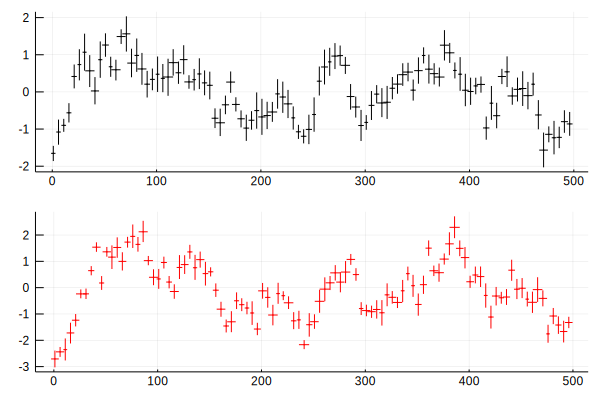

In [2]:
N = 100
sys = ar1_unidir(c_xy = 0.8)
X, Y = example_uncertain_indexvalue_datasets(sys, N, (1, 2), tstep = 5,
    d_xval = Uniform(0.1, 0.3), d_yval = Uniform(0.1, 0.3),
    d_xind = Uniform(1, 3), d_yind = Uniform(1, 3)
    );

qs = [0.05, 0.95] #quantiles
px = plot(legend = false)
#plot!(mean.(X.indices), mean.(X.values), label = "X", c = :black)
plot!(X, label = "X", marker = stroke(0.01, :black), ms = 1, c = :black, qs, qs)

py = plot(legend = false)
#plot!(mean.(Y.indices), mean.(Y.values), label = "Y", c = :red)
plot!(Y, label = "Y", marker = stroke(0.01, :red), ms = 1, c = :red, qs, qs)

plot(px, py, layout = grid(2, 1))

Create a fine-grained interpolation grid over the range of the data.

In [3]:
tmin = max(minimum(mean.(X.indices)), minimum(mean.(Y.indices)))
tmax = max(maximum(mean.(X.indices)), maximum(mean.(Y.indices)))
intp_grid = tmin:0.01:tmax

1.0:0.01:496.0

Decide on a coarser resolution at which we want to analyse the data. Pick all the linearly interpolated data that falls in each bin and summarise it using the `mean` function.

In [4]:
binstep = 5
left_bin_edges = tmin:binstep:tmax
r = InterpolateAndBin(mean, left_bin_edges, Linear(), intp_grid, Flat(OnGrid()))

InterpolateAndBin{Linear}(Statistics.mean, 1.0:5.0:496.0, Linear(), 1.0:0.01:496.0, Flat(OnGrid()))

Draw some interpolated-and-binned realisations and plot them:

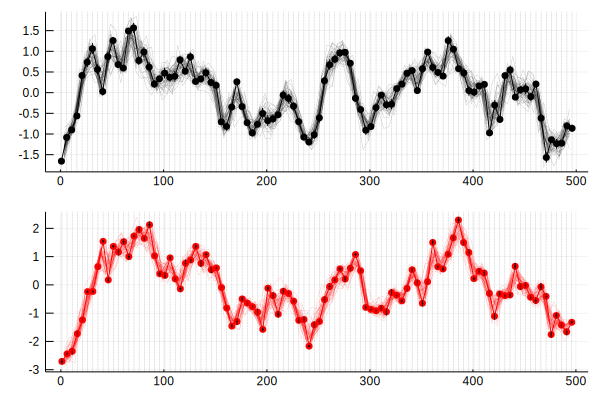

In [5]:
g = left_bin_edges[1:end-1] .+ step(left_bin_edges)/2

pX = plot(legend = false)
plot!(mean.(X.indices), mean.(X.values), label = "X", c = :black)
plot!(X, label = "X", marker = stroke(0.01), c = :black)
vline!(left_bin_edges, c = :black, alpha = 0.5, lw = 0.5, ls = :dot)

for i = 1:50
    plot!(g, resample(X, r), label = "", alpha = 0.3, lw = 0.3, c = :black)
end

pY = plot(legend = false)
plot!(mean.(Y.indices), mean.(Y.values), label = "Y", c = :red)
plot!(Y, label = "Y", marker = stroke(0.01), c = :red)
vline!(left_bin_edges, c = :black, alpha = 0.5, lw = 0.5, ls = :dot)

for i = 1:50
    plot!(g, resample(Y, r), label = "", alpha = 0.3, lw = 0.3, c = :red)
end

plot(pX, pY, layout = grid(2, 1))

Okay, that looks reasonable! Let's apply a causality test.

## Defining an `InterpolateBinTest`

We'll use a predictive asymmetry test as the causality test. Then we just couple that test with the interpolation-and-binning scheme, and compute the causality between `X` and `Y` over 100 independent realisations.

In [6]:
# Causality test 
k, l, m = 1, 1, 1 # embedding parameters
n_subdivisions = floor(Int, N^(1/(k + l + m + 1)))
state_space_binning = RectangularBinning(n_subdivisions)
ηs = -8:8
te_test = VisitationFrequencyTest(k = k, l = l, m = m,
            binning = state_space_binning, 
            ηs = ηs, b = 2) # use base-2 logarithms
pa_test = PredictiveAsymmetryTest(predictive_test = te_test)

# Define interpolate-and-bin test. Draw 100 independent realisations.
ib_test = InterpolateBinTest(pa_test, r, 100)

## Compute causality statistic

In [8]:
res_xy = causality(X, Y, ib_test);
res_yx = causality(Y, X, ib_test);

Summarise and get the mean and standard deviation for each prediction lag $\eta$. Plot it.

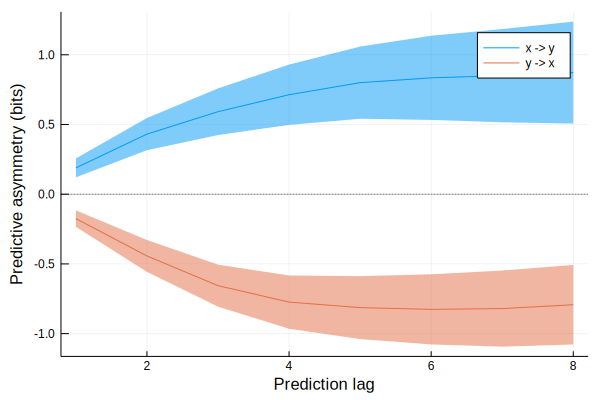

In [9]:
RES_xy = hcat(res_xy...)
RES_yx = hcat(res_yx...)

plot(xlabel = "Prediction lag", ylabel = "Predictive asymmetry (bits)")
plot!(1:maximum(ηs), mean(RES_xy, dims = 2), ribbon = std(RES_xy, dims = 2), label = "x -> y")
plot!(1:maximum(ηs), mean(RES_yx, dims = 2), ribbon = std(RES_yx, dims = 2), label = "y -> x")
hline!([0], lw = 1, ls = :dot, c = :black, label = "")

We get the expected predictive asymmetry! Nice.